In [110]:
import os
import re
import pandas as pd
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
from matplotlib import pyplot

In [111]:
DATA = "data"
POS = "pos"
NEG = "neg"
ACL_IMDB = "aclImdb"
TRAIN = "train"
TEST = "test"

In [42]:
from nltk.corpus import stopwords

In [99]:
dataset_parts = (TRAIN, TEST)
text_sentiments = (POS, NEG)

filename_parser = re.compile(r"(?P<id>\d+)_(?P<rating>\d{,2}).txt")

train_data_list = []
test_data_list = []

for part in dataset_parts:
    for sentiment in text_sentiments:
        for filename in os.listdir(os.path.join(DATA, ACL_IMDB, part, sentiment)):
            with open(os.path.join(DATA, ACL_IMDB, part, sentiment, filename), "r", encoding="utf-8") as file:
                if part == TRAIN:
                    needed_list = train_data_list
                else:
                    needed_list = test_data_list
                needed_list.append({"text": file.read().strip(),
                                    "sentiment": int(sentiment == POS),
                                    "rating": int(filename_parser.match(filename).group("rating"))})

In [100]:
data_train = pd.DataFrame(train_data_list)
data_test = pd.DataFrame(test_data_list)

In [55]:
stopwords_en = stopwords.words("english")

In [141]:
def tp(y_true, y_pred):
    sum_true = 0
    for true, pred in zip(y_true, y_pred):
        if true and pred:
            sum_true += 1
    return sum_true

def fp(y_true, y_pred):
    sum_fp = 0
    for true, pred in zip(y_true, y_pred):
        if not true and pred:
            sum_fp += 1
    return sum_fp

def tn(y_true, y_pred):
    sum_tn = 0
    for true, pred in zip(y_true, y_pred):
        if not true and not pred:
            sum_tn += 1
    return sum_tn

def fn(y_true, y_pred):
    sum_fn = 0
    for true, pred in zip(y_true, y_pred):
        if true and not pred:
            sum_fn += 1
    return sum_fn

In [142]:
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix

In [174]:
vectorizer = TfidfVectorizer(stop_words=stopwords_en)
def evaluate_model(model_class, param_grid):
    pipeline = Pipeline([("vect", vectorizer),
                         ("clf", model_class())])
    grid_search = GridSearchCV(pipeline, param_grid, n_jobs=-1, verbose=1)
    grid_search.fit(data_train.text, data_train.sentiment)
    predictions = grid_search.best_estimator_.predict(data_test.text)
    probabilities = grid_search.best_estimator_.predict_proba(data_test.text)
    current_test_df = pd.DataFrame(data_test.copy())
    current_test_df["probabilities"] = probabilities[:,1]
    print(classification_report(data_test.sentiment, predictions))
    print("SkLearn conf matrix")
    print(confusion_matrix(data_test.sentiment, predictions))
    print("My conf matrix")
    print(f"{tn(data_test.sentiment, predictions)} {fp(data_test.sentiment, predictions)}\n{fn(data_test.sentiment, predictions)} {tp(data_test.sentiment, predictions)}")
    lr_auc = roc_auc_score(data_test.sentiment, predictions)
    lr_fpr, lr_tpr, _ = roc_curve(data_test.sentiment, predictions)
    pyplot.plot(lr_fpr, lr_tpr, marker='.', label='Model')
    pyplot.xlabel('False Positive Rate')
    pyplot.ylabel('True Positive Rate')
    pyplot.legend()
    pyplot.show()
    print("The least positive reviews")
    print(current_test_df.nsmallest(15, columns=["probabilities"]))
    print("The most positive reviews")
    print(current_test_df.nlargest(15, columns=["probabilities"]))

# Logistic Regression

Fitting 3 folds for each of 18 candidates, totalling 54 fits


/Users/grigoriyarshinov/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done  54 out of  54 | elapsed:  4.5min finished
/Users/grigoriyarshinov/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


{'mean_fit_time': array([ 6.39575235, 35.9665486 ,  7.11919999, 45.34167624,  8.59596833,
       43.98543835,  7.63763134, 54.05744235,  9.24473524, 58.63155834,
        9.56113132, 58.76267799,  9.11840431, 71.06241155,  8.94356998,
       67.20721801, 10.88380925, 48.02898534]), 'std_fit_time': array([0.11396003, 0.19479813, 0.16690299, 3.47523523, 1.09718627,
       4.64067137, 0.41641335, 6.82809469, 0.72358321, 8.7061554 ,
       0.61618642, 9.2431872 , 0.08013059, 0.91150304, 0.8722042 ,
       1.95063342, 0.24273842, 3.11246722]), 'mean_score_time': array([2.86752971, 7.05082313, 3.04372605, 6.46899374, 2.78969137,
       7.43063132, 2.63946096, 6.92835236, 2.82209436, 7.40715122,
       2.98559769, 7.2697889 , 2.89905532, 8.01017499, 2.85659989,
       5.81031664, 2.98216271, 2.98312306]), 'std_score_time': array([0.03427124, 0.07658611, 0.32367753, 0.18764859, 0.17653687,
       0.87306821, 0.11394228, 0.49128213, 0.34192201, 1.21007809,
       0.31885903, 0.52946635, 0.310009

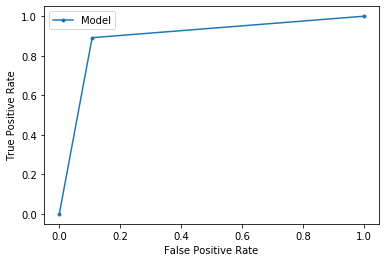

The least positive reviewes
                                                    text  sentiment  rating  \
19212  As you can tell from the other comments, this ...          0       2   
13009  I rented this movie today... worst movie EVER....          0       1   
23186  This movie was a complete waste of time. The s...          0       1   
12884  This was truly horrible. Bad acting, bad writi...          0       1   
23866  I'm in a film class and i know that i don't kn...          0       1   
18200  One of the worst movies I've ever seen!!! Abso...          0       1   
13634  This movie is pathetic in every way possible. ...          0       1   
16975  Predator Island starts as six friends, Eric (T...          0       1   
23098  This is just the same old crap that is spewed ...          0       2   
15319  This was obviously the worst movie ever made.....          0       1   
24977  The horrific production doesn't qualify as a "...          0       1   
17462  Larry Bishop dire

In [173]:
parameters = {
    'vect__max_df': (0.5, 0.75, 1.0),
    'vect__ngram_range': ((1, 1), (1, 2)),  # unigrams or bigrams
    'vect__use_idf': (True,),
    'clf__C': (1, 5, 30),
    'clf__penalty': ('l2',),
    'clf__solver': ("lbfgs",)
}
evaluate_model(LogisticRegression, parameters)

# SGD Classifier

Fitting 3 folds for each of 24 candidates, totalling 72 fits


/Users/grigoriyarshinov/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed:  2.6min finished


              precision    recall  f1-score   support

           0       0.89      0.89      0.89     12500
           1       0.89      0.90      0.89     12500

    accuracy                           0.89     25000
   macro avg       0.89      0.89      0.89     25000
weighted avg       0.89      0.89      0.89     25000

SkLearn conf matrix
[[11106  1394]
 [ 1309 11191]]
My conf matrix
11106 1394
1309 11191


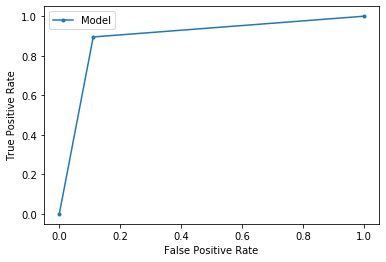

The least positive reviews
                                                    text  sentiment  rating  \
945    Haggard: The Movie is the real life story of R...          1      10   
1944   What is your freaking problem? Do you have not...          1       8   
2175   When the movie first started I thought cheesy....          1       9   
2419   David Morse and Andre Braugher are very talent...          1       9   
4078   This was Laurel and Hardy's last silent film f...          1       7   
4756   "Comanche Moon" had everything going for it. F...          1       7   
5611   I haven't read the Anne Rice novel that this m...          1       7   
5660   Actually I'll admit I'm a political junkie, so...          1       8   
8148   Simon Wests pg-13 thriller about a babysitter ...          1       7   
8552   OK, yes its bad, yes its complete fluff, yes i...          1       9   
9129   House of Dracula works from the same basic pre...          1       7   
10374  Un Gatto nel Cerve

In [176]:
parameters = {
    'vect__max_df': (0.5, 0.75, 1.0),
    'vect__ngram_range': ((1, 1), (1, 2)),  # unigrams or bigrams
    'vect__use_idf': (True,),
    'clf__alpha': (1, 0.1, 0.0001, 0.000001),
    'clf__penalty': ('l2',),
    'clf__loss': ["modified_huber"]
}
evaluate_model(SGDClassifier, parameters)

# Naive Bayes

Fitting 3 folds for each of 24 candidates, totalling 72 fits


/Users/grigoriyarshinov/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed:  2.6min finished


              precision    recall  f1-score   support

           0       0.85      0.89      0.87     12500
           1       0.88      0.84      0.86     12500

    accuracy                           0.86     25000
   macro avg       0.87      0.86      0.86     25000
weighted avg       0.87      0.86      0.86     25000

SkLearn conf matrix
[[11138  1362]
 [ 2033 10467]]
My conf matrix
11138 1362
2033 10467


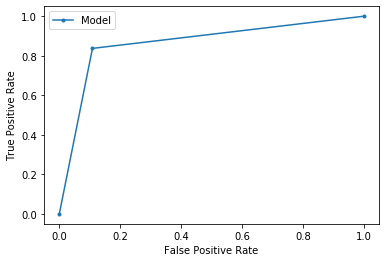

The least positive reviews
                                                    text  sentiment  rating  \
19212  As you can tell from the other comments, this ...          0       2   
19107  This movie is a complete and utter waste of ti...          0       1   
18200  One of the worst movies I've ever seen!!! Abso...          0       1   
13009  I rented this movie today... worst movie EVER....          0       1   
20949  I've seen a lot of bad movies in my life. Date...          0       1   
24952  Granted, HOTD 2 is better than the Uwe Boll cr...          0       4   
16975  Predator Island starts as six friends, Eric (T...          0       1   
17462  Larry Bishop directs, writes, and leads this s...          0       1   
17014  My original comment on this particular title w...          0       1   
14750  OK if you are looking for a fun lesbian romp. ...          0       2   
23624  That's what me and my friends kept asking each...          0       1   
17072  simply i just watc

In [178]:
parameters = {
    'vect__max_df': (0.5, 0.75, 1.0),
    'vect__ngram_range': ((1, 1), (1, 2)),  # unigrams or bigrams
    'vect__use_idf': (True,),
    'clf__alpha': [0.0001, 0.001, 0.01, 1.0]
}
evaluate_model(MultinomialNB, parameters)